In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
# from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from debugging.show import *
from custom_model_builder import build_sam2_predict

/home/guests/tuna_gurbuz/prototype


In [2]:
model_size_dict = {
    'base': {
        'config': '05_24_10_21/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/05_24_10_21/checkpoints/checkpoint.pt',
        },
}

# Model
model_size = 'base'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
# submodel = build_sam2(config, ck, 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
submodel, object_labels = build_sam2_predict(config, ck, device=device)
im_pred = SAM2ImagePredictor(submodel)
im_pred._bb_feat_sizes = [
        (128, 128),
        (64, 64),
        (32, 32),
    ]

OmegaConf resolved successfully


/home/guests/tuna_gurbuz/prototype/custom_models/models/sam2former/msdeformattn.py:310: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


In [3]:
# Dataset
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('train',
                           len_video=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

TypeError: MiniDataset.__init__() missing 1 required positional argument: 'num_frames'

In [ ]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False

while True:
    if if_break:
        break
    idx = np.random.randint(0, len(test_dataset))
    # idx = 25424
    print(f'Index: {idx}')
    frame_obj_list, frames_segmentation_mask = test_dataset[idx]
    for i in range(len_video):
        image = frame_obj_list.frames[i].data
        for j in range(len_objects):
            exist = torch.any(frame_obj_list.frames[i].objects[j].segment == True)
            gt_mask = toPILimage(frame_obj_list.frames[i].objects[j].segment/255) if exist else None
            if_break = True if exist else if_break

unnormalized_image = toPILimage(revert_transform(image))
image = toPILimage(image)
im_pred.set_image(unnormalized_image)

Index: 0


In [ ]:
# Point Copy-Paste from the sam2_tune
O = len_objects
points = torch.tensor([[i,i] for i in object_labels]).unsqueeze(1)
labels = torch.tensor([[1]]).tile((O,1))
print(f'Points: {points.data}')
print(f'Labels: {labels.item()}')

Points: tensor([[[10, 10]]])
Labels: 1


In [ ]:
# Predict
multimask_output = True
masks, scores, logits = im_pred.predict(
point_coords=points,
point_labels=labels,
multimask_output=multimask_output,
)
best_masks = deepcopy(masks)
if multimask_output:
    masks = masks[None,:,:,:] if len(masks.shape) == 3 else masks
    scores = scores[None,:] if len(scores.shape) == 1 else scores
    sorted_ind = np.argsort(scores, axis=1)[:,-1]
    obj_ind = np.arange(len_objects)
    best_masks = masks[obj_ind,sorted_ind]
    best_scores = scores[obj_ind,sorted_ind]
    # best_logits = logits[obj_ind,sorted_ind]
# for idx, mask in enumerate(best_masks):
#     toPILimage((mask*255).astype(np.uint8)).show()

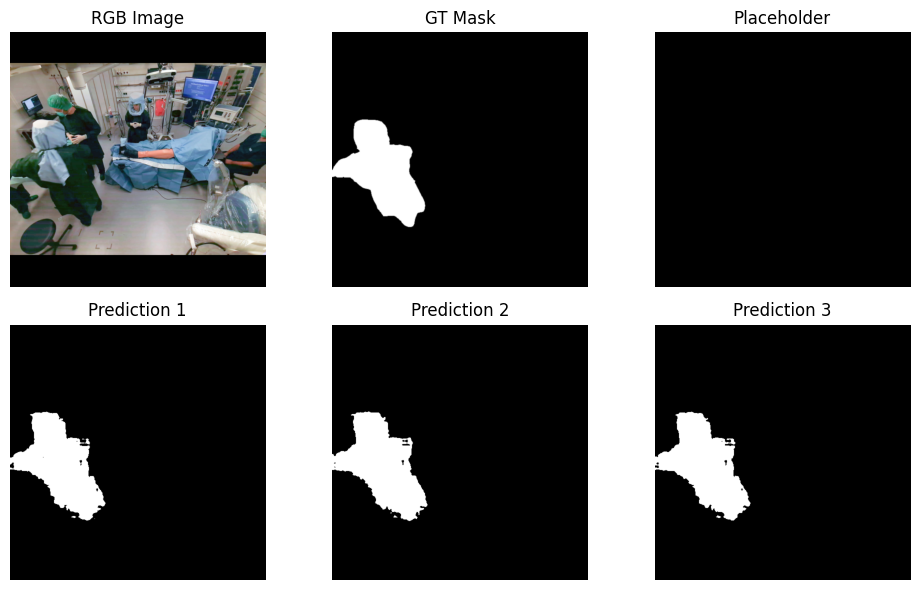

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

obj_out_idx = 0
black_placeholder = np.zeros_like(gt_mask)  # Black image placeholder

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# First row (RGB, GT, Black Placeholder)
axes[0, 0].imshow(unnormalized_image)
axes[0, 0].set_title("RGB Image")

axes[0, 1].imshow(gt_mask, cmap='gray')
axes[0, 1].set_title("GT Mask")

axes[0, 2].imshow(black_placeholder, cmap='gray')
axes[0, 2].set_title("Placeholder")

# Second row (Predictions)
axes[1, 0].imshow(masks[obj_out_idx,0], cmap='gray')
axes[1, 0].set_title("Prediction 1")

axes[1, 1].imshow(masks[obj_out_idx,1], cmap='gray')
axes[1, 1].set_title("Prediction 2")

axes[1, 2].imshow(masks[obj_out_idx,2], cmap='gray')
axes[1, 2].set_title("Prediction 3")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()